In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from cot.data import Parity, BinaryCopy, Copy
from cot.config import RAW_DIR, CHECKPOINT_DIR
from cot.models import Transformer, TransformerConfig

import logging
logging.basicConfig(level=logging.INFO)

## DataLoader

In [3]:
Problem = BinaryCopy

In [4]:
rng = np.random.default_rng()
nb_len = 8
lengths = list(np.arange(nb_len) + 1)

split_probas_by_len =  .75 * np.ones(len(lengths))
probas_by_len = np.ones(len(lengths), dtype=float)
probas_by_len /= probas_by_len.sum()

max_nb_data_per_len = 10000

In [5]:
if Problem.prefix == 'copy':
    Problem(vocab_size=20)

Problem.generate_datafiles(max_nb_data_per_len, split_probas_by_len, rng)

trainset = Problem()
trainset.set_as_trainset(lengths, probas_by_len)

testset = Problem()
testset.set_as_testset(lengths)

INFO:cot.data.data_processing:Generating data. Saving in /home/vivc/Code/llm/compositionality/data/raw/binary_copy
INFO:cot.data.data_processing:Loading training data for binary_copy problem.
INFO:cot.data.data_processing:Setting sampler.
INFO:cot.data.data_processing:Loading test data for binary_copy problem.


In [6]:
loader = DataLoader(trainset, batch_size=len(trainset), sampler=trainset.sampler)
print(f"number of data: {len(trainset)}")

number of data: 382


## Training loop

In [7]:
config = TransformerConfig(
    vocab_size=torch.max(trainset.data).item() + 1,
    emb_dim=128,
    pos_emb=True,
    seq_len=len(trainset[0]),
    emb_dropout=0.1,
    n_head=2,
    n_layer=2,
)

In [8]:
model = Transformer(config)
print(model)

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(19, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)


In [9]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

nb_epochs = 300
eval_freq = 1
nb_eval = nb_epochs // eval_freq + 1

checkpoint_freq = 30
overwrite_checkpoint = True
check_dir = CHECKPOINT_DIR / Problem.prefix
check_dir.mkdir(parents=True, exist_ok=True)

model = Transformer(config)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

losses = np.empty(nb_epochs)
acc_by_len = np.empty((nb_eval, len(lengths))) 
test_acc_by_len = np.empty((nb_eval, len(lengths)))
spe_acc = np.empty((nb_eval, 3)) 
test_spe_acc = np.empty((nb_eval, 3)) 

# TODO: load from checkpoint
# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

t = 0

while True:

    # evaluation
    if not t % eval_freq:
        with torch.no_grad():
            model.eval()
            _, seq_err, spe_err = trainset.eval_model(model, special=True)
            _, test_seq_err, test_spe_err = testset.eval_model(model, special=True)
            accuracy = 1 - (seq_err * probas_by_len).sum().item()
            test_accuracy = 1 - (test_seq_err * probas_by_len).sum().item()

        print(f'Epoch {t:5d}, Accuracy: {accuracy:.4f}, {test_accuracy:.4f}')
        s = t // eval_freq
        acc_by_len[s] = 1 - seq_err.numpy()
        test_acc_by_len[s] = 1 - test_seq_err.numpy()
        spe_acc[s] = 1 - spe_err
        test_spe_acc[s] = 1 - test_spe_err

    if t == nb_epochs:
        break

    t  = t + 1

    # training
    model.train()
    running_loss = 0
    accuracy = 0
    for sequence in loader:
        sequence = sequence.to(device=device, dtype=torch.long)

        inputs = sequence[:, :-1]
        targets = sequence[:, 1:]

        # only train on the chain-of-thoughts process, EoI is represented by 1 in our case
        ind = targets == 1
        cot_mask = ind.cumsum(axis=1)
        cot_mask[ind] = 0
        cot_mask = cot_mask.to(dtype=bool)

        logits = model(inputs)
        loss = F.cross_entropy(logits[cot_mask].view(-1, logits.size(-1)), targets[cot_mask].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            running_loss += loss.item()
    
    losses[t - 1] = loss

    print(f'Epoch {t:5d}, Loss: {running_loss:.4f}')

    # checkpointing
    if not t % checkpoint_freq or t == nb_epochs:
        if overwrite_checkpoint:
            path = check_dir / 'model.pth'
        else:
            path = check_dir / f'model_{t}.pth'

        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'losses': losses,
            'acc_by_len': acc_by_len,
            'test_acc_by_len': test_acc_by_len,
            'spe_acc': spe_acc,
            'test_spe_acc': test_spe_acc,
        }, path)


cpu
Epoch     0, Accuracy: 0.0000, 0.0000
Epoch     1, Loss: 1.8178
Epoch     1, Accuracy: 0.0000, 0.0000
Epoch     2, Loss: 1.1226
Epoch     2, Accuracy: 0.0000, 0.1250
Epoch     3, Loss: 0.7318
Epoch     3, Accuracy: 0.0417, 0.1250
Epoch     4, Loss: 0.5940
Epoch     4, Accuracy: 0.0430, 0.0039
Epoch     5, Loss: 0.5075
Epoch     5, Accuracy: 0.0833, 0.0000
Epoch     6, Loss: 0.4636
Epoch     6, Accuracy: 0.0000, 0.0000
Epoch     7, Loss: 0.4493
Epoch     7, Accuracy: 0.0000, 0.0000
Epoch     8, Loss: 0.4327
Epoch     8, Accuracy: 0.0000, 0.0000
Epoch     9, Loss: 0.4228
Epoch     9, Accuracy: 0.0000, 0.0000
Epoch    10, Loss: 0.4151
Epoch    10, Accuracy: 0.0423, 0.0039
Epoch    11, Loss: 0.3737
Epoch    11, Accuracy: 0.2142, 0.0234
Epoch    12, Loss: 0.3502
Epoch    12, Accuracy: 0.2220, 0.1406
Epoch    13, Loss: 0.3831
Epoch    13, Accuracy: 0.2220, 0.1406
Epoch    14, Loss: 0.3730
Epoch    14, Accuracy: 0.2148, 0.1406
Epoch    15, Loss: 0.3674
Epoch    15, Accuracy: 0.2129, 0.132

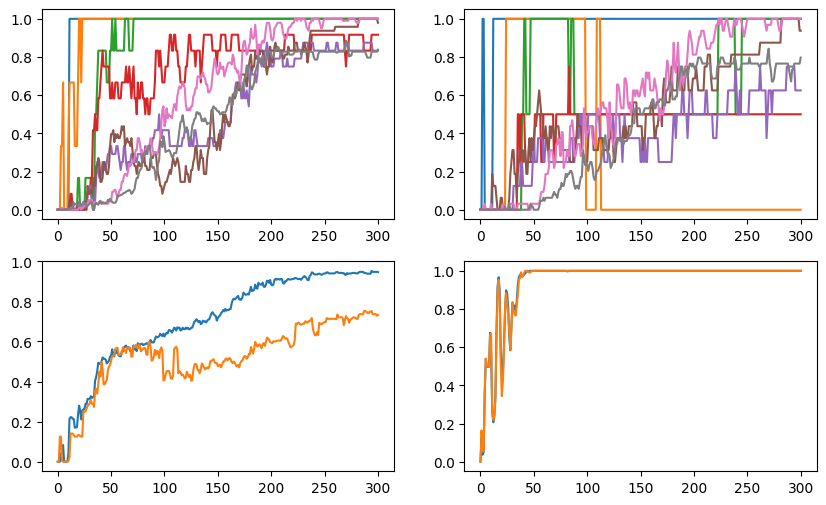

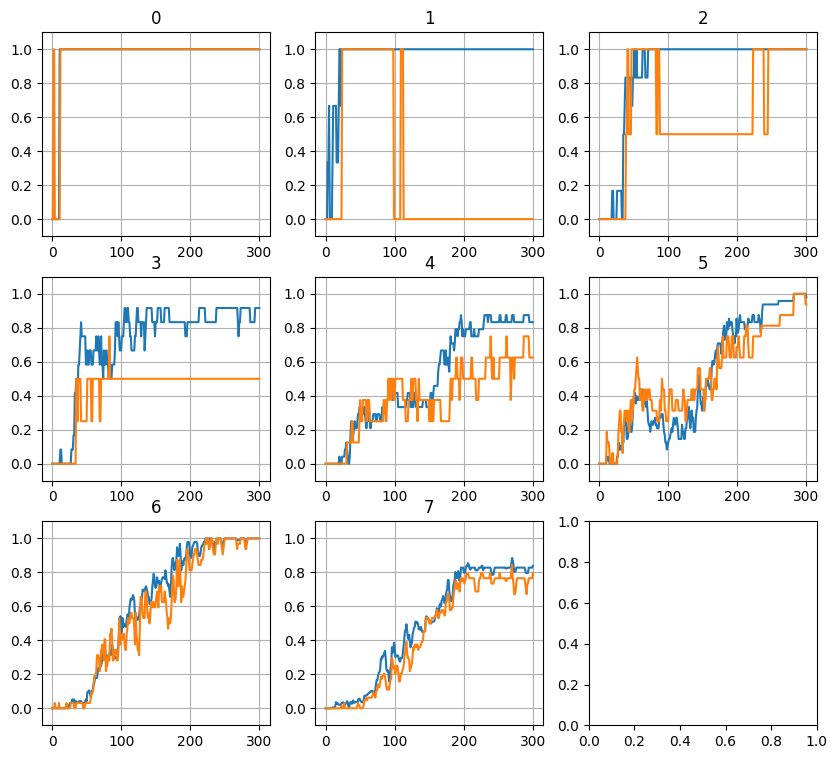

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(acc_by_len)
axes[0, 1].plot(test_acc_by_len)
axes[1, 0].plot(acc_by_len.mean(axis=1))
axes[1, 0].plot(test_acc_by_len.mean(axis=1))
axes[1, 1].plot(spe_acc[:, 2])
axes[1, 1].plot(test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

fig, axes = plt.subplots(nb_len // 3 + (1 if nb_len % 3 else 0), 3, figsize=(10, 9))
for i in range(nb_len):
    axes[i // 3, i % 3].plot(acc_by_len[:, i])
    axes[i // 3, i % 3].plot(test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()